# EEG Spectrogram Generation and Dataset Splitting for Sleep Apnea Classification

## Dataset Description

The dataset for this study is drawn from the C3–A2 EEG channel of overnight polysomnography (PSG) recordings in the PhysioNet repository ([UCDDB Sleep Apnea Database](https://archive.physionet.org/physiobank/database/ucddb/)). Each recording is annotated with:  
- **Apnea–Hypopnea Index (AHI):** a continuous measure of respiratory events per hour  
- **Total sleep duration:** the length of the recording during sleep  

Although AHI is a continuous variable, we stratify it into four clinically meaningful categories to capture both between‐ and within‐group variation:

| Category   | AHI Range (events/hr) | Clinical Label |
|:-----------|:----------------------|:---------------|
| Normal     | AHI < 5               | Normal         |
| Mild       | 5 ≤ AHI < 15          | Mild           |
| Moderate   | 15 ≤ AHI < 30         | Moderate       |
| Severe     | AHI ≥ 30              | Severe         |

## Imports

In [ ]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import mne

## User Settings

In [ ]:
# Directory containing your raw EDF files
raw_dir      = '../data/eeg_signals'

# Directory where cleaned spectrogram PNGs will be saved
out_dir      = '../data/spectrograms_by_class'
os.makedirs(out_dir, exist_ok=True)

# EEG channel to process (must exactly match one of raw.ch_names)
channel_name = 'C3A2'

# Length of each epoch, in seconds
epoch_sec    = 30

# STFT parameters
window       = 'hann'      # window function for STFT
nfft         = 256         # number of FFT points (also used as nperseg)
cmap         = 'viridis'   # colormap for spectrogram plotting
dpi          = 150         # resolution (dots per inch) for saved PNGs

# After computing a global color range, we will skip any epoch
# that contains a time bin entirely at or below the floor (all-purple).

## First Pass – Compute Global dB Range

In [ ]:
# Create lists to collect per-epoch minimum and maximum dB values
all_db_mins = []
all_db_maxs = []

# Iterate over every EDF file in raw_dir
for edf_path in glob.glob(os.path.join(raw_dir, '*.edf')):
    # Load EDF and read its sampling frequency
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    Fs  = raw.info['sfreq']            # sampling frequency in Hz
    L   = int(epoch_sec * Fs)          # number of samples per epoch
    nperseg  = nfft                    # STFT window length = FFT size
    noverlap = nperseg // 2            # 50% overlap

    # Extract the selected channel’s data as a 1D numpy array
    pick_idx = raw.ch_names.index(channel_name)
    sig      = raw.get_data(picks=[pick_idx])[0]

    # Compute how many full epochs fit into this recording
    nseg = len(sig) // L

    # For each epoch, compute the STFT and record dB min/max
    for i in range(nseg):
        seg = sig[i*L:(i+1)*L]  # slice out the i-th 30s segment

        # Compute power spectrogram using STFT
        f, t, Sxx = spectrogram(
            seg,
            fs=Fs,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft
        )

        # Convert power to decibels (add small constant to avoid log(0))
        Sxx_db = 10 * np.log10(np.abs(Sxx) + 1e-12)

        # Record this epoch’s minimum and maximum dB values
        all_db_mins.append(Sxx_db.min())
        all_db_maxs.append(Sxx_db.max())

# Determine a single color‐scale range (global_vmin, global_vmax)
global_vmin = min(all_db_mins)
global_vmax = max(all_db_maxs)

print(f"Global dB range: {global_vmin:.1f} to {global_vmax:.1f} dB")

/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/2143399175.py:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/2143399175.py:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/2143399175.py:8: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/2143399175.py:8: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/fol

Global dB range: -120.0 to 8.5 dB


## Second Pass – Plot & Save Spectrograms (Skip All‑Purple Columns)

In [ ]:
# Regenerate each spectrogram, but skip any epoch that has even one time bin
# completely at or below the floor (all-purple). This ensures no half-purple images.

for edf_path in sorted(glob.glob(os.path.join(raw_dir, '*.edf'))):
    # Reload EDF and extract sampling frequency
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    Fs  = raw.info['sfreq']
    L   = int(epoch_sec * Fs)           # samples per 30s epoch
    nperseg  = nfft                     # STFT window length
    noverlap = nperseg // 2             # 50% overlap

    # Extract the chosen channel’s data
    pick_idx = raw.ch_names.index(channel_name)
    sig      = raw.get_data(picks=[pick_idx])[0]

    # Base filename (without extension) for output naming
    base = os.path.splitext(os.path.basename(edf_path))[0]
    nseg = len(sig) // L                # number of full epochs

    for i in range(nseg):
        seg = sig[i*L:(i+1)*L]          # slice one 30s epoch

        # Compute STFT → power spectrogram
        f, t, Sxx = spectrogram(
            seg,
            fs=Fs,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            nfft=nfft
        )
        Sxx_db = 10 * np.log10(np.abs(Sxx) + 1e-12)

        # 1) If the entire epoch is below or equal to the floor, skip it
        if Sxx_db.max() <= global_vmin:
            continue

        # 2) Compute maximum dB value for each time bin (column)
        col_maxes = Sxx_db.max(axis=0)  # shape: (n_time_bins,)

        # If any column’s max dB ≤ global_vmin, that column is pure floor → skip
        if np.any(col_maxes <= global_vmin):
            continue

        # Plot the spectrogram using the fixed global_vmin/vmax
        plt.figure()
        plt.imshow(
            Sxx_db,
            origin='lower',                    # frequency=0 at bottom
            aspect='auto',                     # auto-scale axes
            extent=[0, epoch_sec, f.min(), f.max()],
            vmin=global_vmin,                  # uniform lower limit
            vmax=global_vmax,                  # uniform upper limit
            cmap=cmap
        )

        # Remove axes, ticks, titles, and padding so only pixels remain
        plt.axis('off')
        plt.margins(0)
        plt.subplots_adjust(0, 0, 1, 1)

        # Construct a zero-padded filename for this epoch
        out_fn  = f"{base}_{channel_name}_spec_{i+1:03d}.png"
        out_path = os.path.join(out_dir, out_fn)

        # Save the figure as a PNG at the specified DPI
        plt.savefig(
            out_path,
            bbox_inches='tight',
            pad_inches=0,
            dpi=dpi
        )
        plt.close()

print("✓ Spectrogram generation complete. Epochs with any all-purple column were skipped.")

/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/477009216.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/477009216.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/477009216.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/vk/sc311by57qz3bv_c1c3h0bc40000gn/T/ipykernel_21049/477009216.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders

✓ Spectrogram generation complete. Epochs with any all-purple column were skipped.


After running the above cells:

- One PNG is generated for each 30 s epoch of every EDF file, except those epochs
  that would have an all-purple column (i.e., no spectral energy above the floor).
- All saved PNGs share the same decibel color scale (`global_vmin` to `global_vmax`).
- Each image has no axes, ticks, titles, or borders—just the raw spectrogram pixels.
- The resulting PNGs are ready for use with PyTorch transforms (e.g., Resize & Normalize).

## Time–Frequency Spectrograms for EEG-Based Sleep Apnea Classification

Spectrograms offer a powerful approach for EEG-based sleep apnea detection by:  

- **Highlighting Transient Respiratory Events**: Sleep apnea induces brief shifts in cortical rhythms; spectrograms reveal these non-stationary bursts in the time–frequency domain.
- **Enabling Discriminative Feature Learning**: Visualizing power changes across delta, theta, and alpha bands allows classifiers (e.g., CNNs) to pinpoint apneic signatures.
- **Separating Signal from Noise**: Time–frequency representation helps isolate true physiological patterns from movement or electrode artifacts, improving robustness.
- **Harnessing Vision Models**: Treating spectrograms as images leverages state-of-the-art 2D convolutional architectures for superior classification performance.

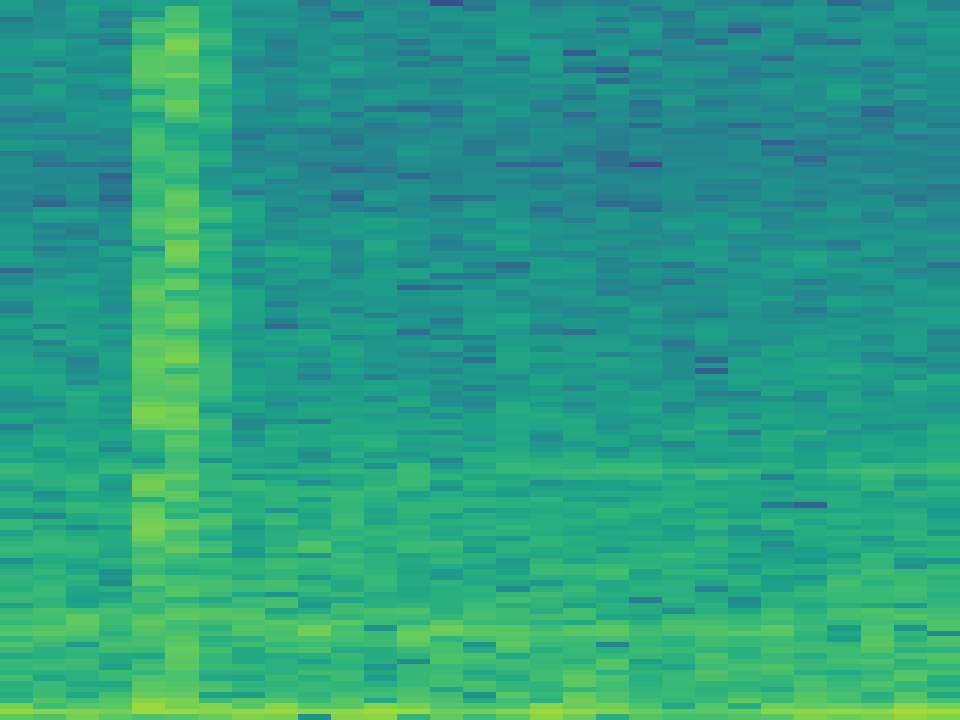

In [2]:
from IPython.display import Image, display
display(Image(filename="../img/ucddb014_C3A2_spec_338.png"))

This spectrogram shows the C3–A2 EEG signal over time (horizontal axis) and frequency (vertical axis, with low frequencies at the bottom and higher ones at the top), and its colors indicate signal strength (blue/green = weaker activity, yellow = stronger). The bright vertical stripe on the left marks a sudden, broadband surge in low-frequency power—typically a K-complex or brief cortical arousal in sleep—which often follows an apnea or hypopnea event (though similar bursts can also arise from movement artifacts).

## Subject Distribution by AHI Category

The following breakdown shows how many subjects and spectrograms fall into each Apnea–Hypopnea Index (AHI) severity group. AHI measures the number of apnea (complete breathing pauses) and hypopnea (partial obstructions) events per hour of sleep. Lower AHI indicates normal breathing, while higher AHI reflects more severe sleep apnea. For each subject, “EEG spectrograms count” denotes the total number of 30‑second EEG spectrogram images generated.

### AHI < 5 (normal)

- **ucddb018** (AHI = 2,  EEG spectrograms count = 822)

**Total:** 1 subject, 822 spectrograms

### 5 ≤ AHI < 15 (mild)

- **ucddb005** (AHI = 13, EEG spectrograms count = 826 => 820)  
- **ucddb007** (AHI = 12, EEG spectrograms count = 813)  
- **ucddb008** (AHI = 5,  EEG spectrograms count = 768 => 727)  
- **ucddb009** (AHI = 12, EEG spectrograms count = 925)  
- **ucddb011** (AHI = 8,  EEG spectrograms count = 901)  
- **ucddb015** (AHI = 6,  EEG spectrograms count = 916 => 900)  
- **ucddb017** (AHI = 12, EEG spectrograms count = 789)  
- **ucddb021** (AHI = 13, EEG spectrograms count = 913 => 903)  
- **ucddb022** (AHI = 7,  EEG spectrograms count = 788)  
- **ucddb026** (AHI = 14, EEG spectrograms count = 838)  

**Total:** 10 subjects, 8 404 spectrograms

### 15 ≤ AHI < 30 (moderate)

- **ucddb002** (AHI = 23, EEG spectrograms count = 749)  
- **ucddb012** (AHI = 25, EEG spectrograms count = 864)  
- **ucddb013** (AHI = 16, EEG spectrograms count = 811)  
- **ucddb019** (AHI = 16, EEG spectrograms count = 852)  
- **ucddb020** (AHI = 15, EEG spectrograms count = 752)  
- **ucddb024** (AHI = 24, EEG spectrograms count = 908 => 907)  

**Total:** 6 subjects, 4 935 spectrograms

### AHI ≥ 30 (severe)

- **ucddb003** (AHI = 51, EEG spectrograms count = 882)  
- **ucddb006** (AHI = 31, EEG spectrograms count = 808 => 785)  
- **ucddb010** (AHI = 34, EEG spectrograms count = 907)  
- **ucddb014** (AHI = 36, EEG spectrograms count = 774)  
- **ucddb023** (AHI = 39, EEG spectrograms count = 861 => 849)  
- **ucddb025** (AHI = 91, EEG spectrograms count = 711)  
- **ucddb027** (AHI = 55, EEG spectrograms count = 893)  
- **ucddb028** (AHI = 46, EEG spectrograms count = 722)  

**Total:** 8 subjects, 6 523 spectrograms

In [ ]:
import random
import shutil

In [ ]:
input_dir = "../data/spectrograms_by_class"
output_dir = "../data/spectrograms_split"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Splitting ratios
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15  # (train + val + test must sum to 1.0)

# Specifications for balanced test subset
balanced_test_per_class = 100

In [ ]:
# List all class‐subfolders in input_dir
classes = [d for d in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, d))]

In [ ]:
# Create directory structure for train/val/test
for split in ("train", "val", "test"):
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

In [ ]:
# For each class, shuffle and split into train/val/test
for cls in classes:
    class_dir = os.path.join(input_dir, cls)
    images = [f for f in os.listdir(class_dir) if f.endswith(".png")]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val   = int(n_total * val_ratio)
    n_test  = n_total - n_train - n_val

    split_indices = {
        "train": images[:n_train],
        "val":   images[n_train : n_train + n_val],
        "test":  images[n_train + n_val : ],
    }

    for split, file_list in split_indices.items():
        for fname in file_list:
            src = os.path.join(class_dir, fname)
            dst = os.path.join(output_dir, split, cls, fname)
            shutil.copy(src, dst)

print("✓ Base 70/15/15 splitting complete.")

✓ Base 70/15/15 splitting complete.


In [ ]:
# Create a balanced test subset (100 images per class) under output_dir/test_balanced
balanced_dir = os.path.join(output_dir, "test_balanced")
for cls in classes:
    src_test_cls = os.path.join(output_dir, "test", cls)
    dst_balanced_cls = os.path.join(balanced_dir, cls)
    os.makedirs(dst_balanced_cls, exist_ok=True)

    all_test_files = [f for f in os.listdir(src_test_cls) if f.endswith(".png")]
    if len(all_test_files) < balanced_test_per_class:
        raise ValueError(
            f"Class '{cls}' has only {len(all_test_files)} test images, "
            f"which is fewer than {balanced_test_per_class}."
        )

    sampled = random.sample(all_test_files, balanced_test_per_class)
    for fname in sampled:
        src = os.path.join(src_test_cls, fname)
        dst = os.path.join(dst_balanced_cls, fname)
        shutil.copy(src, dst)

print(f"✓ Balanced test set created with {balanced_test_per_class} images/class under 'test_balanced/'.")

✓ Balanced test set created with 100 images/class under 'test_balanced/'.
